In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import os
import datetime
import numpy as np

In [2]:
project_dir = str(Path(os.getcwd()).parent)
datasets_path = project_dir + "/datasets/"
df_2018 = pd.read_parquet(datasets_path + "2018_fixed_sesaeet.parquet")
df_2019 = pd.read_parquet(datasets_path + "2019_fixed_sesaeet.parquet")
df_2020 = pd.read_parquet(datasets_path + "2020_fixed_sesaeet.parquet") # When 2020 is cleaned and ready

In [3]:
df = pd.concat([df_2018, df_2019, df_2020]).sort_values("event_start_time", inplace=False).reset_index(inplace=False, drop=True)
df["duration"] = (df["event_end_time"] - df["event_start_time"]).dt.total_seconds()

In [4]:
df["hourofweek"] = df["event_start_time"].dt.dayofweek*24 + df["event_start_time"].dt.hour
weekly_failures = (df.groupby(["vendor", "hourofweek"]).count().reset_index()
                   .rename(columns={"service_id": "num_failures"})
                   [["vendor", "hourofweek", "num_failures"]])
weekly_failures.to_parquet("../../../weekly_failures/cloud_provider_reports.parquet")
weekly_failures

,vendor,hourofweek,num_failures
0,AWS,0,2
1,AWS,1,3
2,AWS,2,5
3,AWS,3,4
4,AWS,4,2
...,...,...,...
348,GCP,146,1
349,GCP,149,1
350,GCP,155,1
351,GCP,162,3


In [20]:
df["dayofyear"] = df["event_start_time"].dt.dayofyear
doy_availability = (df.groupby(["vendor", "dayofyear"]).count().reset_index()
                    .rename(columns={"service_id": "num_failures"})
                    [["vendor", "dayofyear", "num_failures"]])
doy_availability.to_parquet("../../../doy_availability/cloud_provider_reports.parquet")
doy_availability

,vendor,dayofyear,num_failures
0,AWS,2,1
1,AWS,4,1
2,AWS,8,1
3,AWS,9,1
4,AWS,10,1
...,...,...,...
473,GCP,347,1
474,GCP,349,1
475,GCP,353,5
476,GCP,355,2


In [16]:
dayofyear = pd.DataFrame({
    "dayofyear": np.tile(np.arange(1, 366, dtype=int), 3),
    "count": np.tile(np.zeros(365, dtype=int), 3),
    "vendor": np.concatenate([np.repeat("AWS", 365), np.repeat("Azure", 365), np.repeat("GCP", 365)])
})
for vendor in df["vendor"].unique():
    partial_df = df.loc[df["vendor"] == vendor, ""].reset_index(drop=True)
    doy = partial_df["event_start_time"].dt.dayofyear
    

,dayofyear,count,vendor
0,1,0,AWS
1,2,0,AWS
2,3,0,AWS
3,4,0,AWS
4,5,0,AWS
...,...,...,...
1090,361,0,AWS
1091,362,0,AWS
1092,363,0,AWS
1093,364,0,AWS


In [6]:
df.to_parquet("../../../iat_dur_med/cloud_provider_reported.parquet")

In [14]:
# Finding total number of failure events
# Status analysis
total = 0
for vendor in df["vendor"].unique():
    df_vendor = df[df["vendor"] == vendor]
    count = df_vendor["service_id"].count()
    severe_count = df_vendor[df_vendor["status"] == 2]["service_id"].count()
    moderate_count = df_vendor[df_vendor["status"] == 1]["service_id"].count()
    small_count = df_vendor[df_vendor["status"] == 0]["service_id"].count()
    total += count
    print("%s\nTotal nr failure events: %d\nNr severe failures: %d\nNr moderate failures: %d\nNr small failures: %d" % (vendor, count, severe_count, moderate_count, small_count), end="\n\n")
    
print("total: " + str(total))


GCP
Total nr failure events: 442
Nr severe failures: 0
Nr moderate failures: 345
Nr small failures: 97

AWS
Total nr failure events: 380
Nr severe failures: 39
Nr moderate failures: 333
Nr small failures: 4

Azure
Total nr failure events: 211
Nr severe failures: 0
Nr moderate failures: 0
Nr small failures: 0

total: 1033


In [15]:
# Manual inspection for the analyzing which services have failed the most 
total = 0
for vendor in df["vendor"].unique():
    df_vendor = df[df["vendor"] == vendor]
    service_counts = df_vendor["service_name"].value_counts()
    total = df_vendor["service_name"].count()
    service_percentage = round((service_counts / total) * 100, 2)
    
    print(vendor)
    print(service_percentage)
    

GCP
service_name
Network                                   11.76
Google Compute Engine                      8.37
Google App Engine                          7.01
Google Cloud Storage                       6.11
Google Stackdriver                         6.11
Google Kubernetes Engine                   6.11
Google BigQuery                            5.88
Google Cloud Console                       4.75
Google Cloud Functions                     4.52
Google Cloud SQL                           4.07
Google Cloud Infrastructure Components     3.62
Google Cloud Support                       2.49
Google Cloud Datastore                     2.49
Google Cloud Composer                      2.04
Operations                                 2.04
Cloud Firestore                            2.04
Google Cloud Networking                    1.81
Cloud Machine Learning                     1.81
Cloud Memorystore                          1.81
Google Cloud Dataflow                      1.58
Cloud Developer Tools  

In [16]:
# Number of failures per location
for i, vendor in enumerate(df["vendor"].unique()):
    df_vendor = df[df["vendor"] == vendor]
    location_counts = df_vendor["location"].value_counts()
    total = df_vendor["location"].count()
    service_percentage = round((location_counts / total) * 100, 2)

    
    print(vendor, end="\n")
    print(service_percentage)


GCP
location
Unknown            55.33
Multi-region       35.05
us-central1         4.47
us-east4            1.37
us-east1            1.03
europe-west2        0.69
europe-west4        0.69
europe-west1        0.69
asia-southeast1     0.34
europe-north1       0.34
Name: count, dtype: float64
AWS
location
N. Virginia      35.26
Multi-region     10.79
Oregon            9.74
Ireland           6.05
Global            5.79
Sydney            4.21
Ohio              3.68
Seoul             3.68
London            3.16
Tokyo             2.89
Frankfurt         2.89
Sao Paulo         2.63
N. California     2.37
Hong Kong         1.05
Mumbai            1.05
US-West           1.05
Singapore         1.05
GovCloud          0.79
Paris             0.79
US-East           0.79
Montreal          0.26
Name: count, dtype: float64
Azure
location
Multi-region                                                   45.02
West Europe                                                    13.27
East US                         

In [17]:
df["vendor"].unique()

array(['GCP', 'AWS', 'Azure'], dtype=object)

In [22]:
def get_iat_and_dur_med(df, start, end):
    t1 = df[start].sort_values().reset_index(drop=True)
    t2 = np.roll(t1, -1)
    t2[-1] = 0
    iat = (t2 - t1).dt.total_seconds()
    iat = iat[iat > 0]
    iat_stats = iat.quantile([0.5, 0.95]).to_list()
    dur = (df[end] - df[start]).dt.total_seconds()
    dur_stats = dur.quantile([0.5, 0.95]).to_list()
    return pd.DataFrame({
        "metric": ["iat", "iat", "dur", "dur"],
        "quantile": ["median", "tail", "median", "tail"],
        "quantity": iat_stats + dur_stats
    })

In [23]:
# Author: Sacheendra Talluri, Link: <url>
def compute_cdf(partial_df, variate):
    count_df = partial_df.groupby(variate)['event_start_time'].count().reset_index().rename(columns={'event_start_time':'start_count'}).sort_values(variate).reset_index(drop=True)
    count_df['prop'] = count_df['start_count'].values / count_df['start_count'].sum()
    count_df['cdf'] = count_df['prop'].cumsum()
    return count_df

duration_cdf_df_list = []
ia_cdf_df_list = []
ia_count_df_list = []

iat_dur_med_list = []

for vendor in df["vendor"].unique():
    partial_df = df[df["vendor"] == vendor]
    
    partial_duration_cdf_df = compute_cdf(partial_df.copy(), 'duration')
    partial_duration_cdf_df['vendor_cat'] = vendor
    duration_cdf_df_list.append(partial_duration_cdf_df)

    
    # Compute interarrival time
    sorted_partial_df = partial_df.sort_values('event_start_time').reset_index(drop=True)
    ia_arr = sorted_partial_df['event_start_time'].diff()
    partial_ia_df = pd.DataFrame({'ia': ia_arr[1:], 'count':1})
    partial_ia_df['vendor_cat'] = vendor
    ia_count_df = partial_ia_df.groupby('ia')['count'].count().reset_index()
    ia_count_df['prop'] = ia_count_df['count'].values / ia_count_df['count'].sum()
    ia_count_df['cdf'] = ia_count_df['prop'].cumsum()
    ia_count_df['vendor_cat'] = vendor
    ia_count_df_list.append(partial_ia_df)
    ia_cdf_df_list.append(ia_count_df)
    
    iat_dur_med_df = get_iat_and_dur_med(partial_df, "event_start_time", "event_end_time")
    iat_dur_med_df["vendor_cat"] = vendor
    iat_dur_med_list.append(iat_dur_med_df)
    
    
vendor_list = ['AWS', 'GCP', 'Azure']
    
duration_cdf_df = pd.concat(duration_cdf_df_list).reset_index(drop=True)
duration_cdf_df['vendor_cat'] = pd.Categorical(duration_cdf_df['vendor_cat'], ordered=True, categories=vendor_list)

ia_cdf_df = pd.concat(ia_cdf_df_list).reset_index(drop=True)
ia_cdf_df['vendor_cat'] = pd.Categorical(ia_cdf_df['vendor_cat'], ordered=True, categories=vendor_list)

iat_dur_med_df = pd.concat(iat_dur_med_list).reset_index(drop=True)
iat_dur_med_df["vendor_cat"] = pd.Categorical(iat_dur_med_df["vendor_cat"], ordered=True, categories=vendor_list)

ia_count_df = pd.concat(ia_count_df_list).reset_index(drop=True)

In [25]:
iat_dur_med_df.to_parquet("../../../iat_dur_med/cloud_provider_reports.parquet")
iat_dur_med_df

,metric,quantile,quantity,vendor_cat
0,iat,median,15746.00,GCP
1,iat,tail,1070012.25,GCP
2,dur,median,6069.50,GCP
3,dur,tail,53179.85,GCP
4,iat,median,144540.00,AWS
5,iat,tail,1017090.00,AWS
6,dur,median,7470.00,AWS
7,dur,tail,38400.00,AWS
8,iat,median,171000.00,Azure
9,iat,tail,1376574.00,Azure


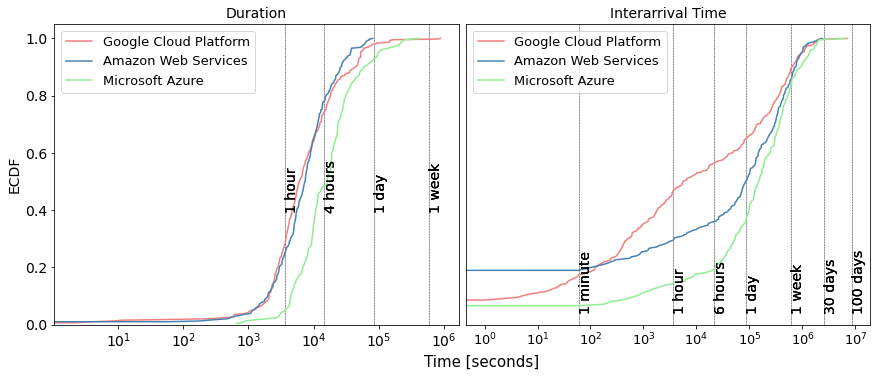

In [22]:
import math
cdf_duration = duration_cdf_df.sort_values('cdf', inplace=False)[['duration', 'cdf', 'vendor_cat']]
cdf_ia = ia_cdf_df.sort_values('cdf', inplace=False)[['ia', 'cdf', 'vendor_cat', 'count']]
cdf_ia['ia'] = cdf_ia['ia'].dt.total_seconds()
cdf_duration['duration'] = cdf_duration[cdf_duration["duration"] >= 0].dropna()
colors = ["lightcoral", "steelblue", "lightgreen"]
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
vendor_map = {
    'AWS': 'Amazon Web Services',
    'GCP': "Google Cloud Platform",
    "Azure": "Microsoft Azure"
}
for i, vendor in enumerate(df["vendor"].unique()):
    vendor_duration = cdf_duration[cdf_duration["vendor_cat"] == vendor]
    vendor_ia = cdf_ia[cdf_ia["vendor_cat"] == vendor]
    
    ax[0].plot(vendor_duration["duration"], vendor_duration["cdf"], label=vendor_map[vendor], color=colors[i])
    ax[0].set_ylim(0, 1.05)
    ax[0].set_title("Duration", fontsize=14)
    ax[0].set_ylabel("ECDF", fontsize=14)
    ax[0].legend(loc='upper left', ncol=1, fontsize=13)
    ax[0].tick_params(axis='both', labelsize=14)
        
    ax[1].plot(vendor_ia["ia"], vendor_ia["cdf"], label=vendor_map[vendor], color=colors[i])
    ax[1].set_title("Interarrival Time", fontsize=14)
    ax[1].legend(loc='upper left', ncol=1, fontsize=13)
    ax[1].tick_params(axis='both', labelsize=13)
    ax[1].get_yaxis().set_visible(False)
#     ax[1].set_xlim(0, 17000000)
    
    # Add vertical text to dashed lines in ax[0]
    hours = [60*60, 60*60*4, 60*60*24, 60*60*24*7]
    hour_str = ['1 hour', '4 hours', '1 day', '1 week']
    for i in range(len(hours)):
        ax[0].vlines(hours[i], ymin=0, ymax=1.1, linewidth=0.5, color='gray', ls='dashed')
        ax[0].text(hours[i], 0.4, hour_str[i], rotation=90, fontsize=14)
    
    hours_2 = [60, 60*60, 60*60*6, 60*60*24, 60*60*24*7, 60*60*24*30, 60*60*24*100]
    hour2_str = ['1 minute', '1 hour', '6 hours', '1 day', '1 week', '30 days', '100 days']
    for i in range(len(hours_2)):
        ax[1].vlines(hours_2[i], ymin=0, ymax=1.1, linewidth=0.5, color='gray', ls='dashed')
        ax[1].text(hours_2[i], 0.05, hour2_str[i], rotation=90, fontsize=14)
        
    ax[0].set_xscale('log')
    ax[0].minorticks_off()
    
    ax[1].set_xscale('log')
    ax[1].minorticks_off()

    ax[0].set_xlabel('Time [seconds]', fontsize=15, loc='right')
    ax[0].xaxis.set_label_coords(+1.2, -0.1)
    
fig.tight_layout(pad=0.01)

plt.savefig(project_dir + "/plots/vendors_duration_ia_ecdf.pdf", dpi=100)

<ipython-input-5-b66aee4e47ef>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  partial_df["date"] = pd.to_datetime(partial_df['event_start_time'], unit='s')
<ipython-input-5-b66aee4e47ef>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  partial_df["year"] = partial_df["date"].dt.year
<ipython-input-5-b66aee4e47ef>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

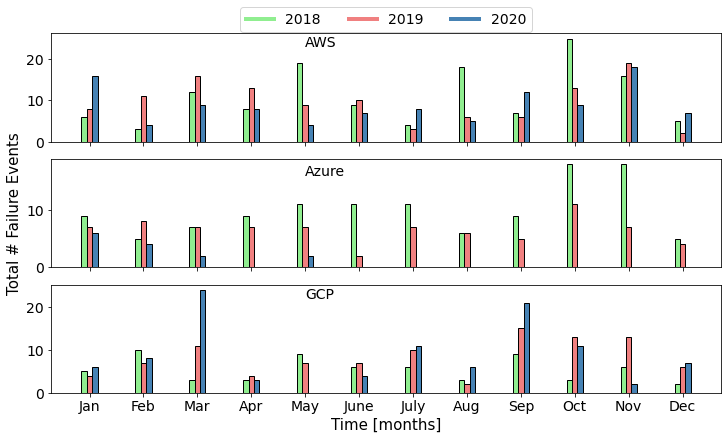

In [5]:
# Total num failure events per month per year
from matplotlib.lines import Line2D

colors=["lightgreen", "lightcoral", "steelblue"]
years = [2018, 2019, 2020]
bar_w = 0.1
custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                Line2D([0], [0], color=colors[1], lw=4),
                Line2D([0], [0], color=colors[2], lw=4)]
colors = ["lightgreen", "lightcoral", "steelblue"]
providers = df.sort_values("vendor")["vendor"].unique()

fig, ax = plt.subplots(3, 1, figsize=(10, 6), constrained_layout=True)

for i, vendor in enumerate(providers):
    partial_df = df[df["vendor"] == vendor]
    partial_df["date"] = pd.to_datetime(partial_df['event_start_time'], unit='s')
    
    partial_df["year"] = partial_df["date"].dt.year
    partial_df["month"] = partial_df["date"].dt.month
    
    bar_locs = []
    bar_heights = []
    months = [i for i in range(1, 13)]
    dfs = {2018: [], 2019: [], 2020: []}
    
    df_vendor = partial_df
    for year in years:
        df_year_vendor = df_vendor[df_vendor["year"] == year]
        if vendor == "Azure":
            df_year_vendor["service_id"] = df_year_vendor["service_id"].index
            
        partial_grouped_df = df_year_vendor.groupby('month')['service_id'].unique().str.len().reset_index().rename(columns={'service_id': 'event_sum'})
        
        for m in months:
            if m not in partial_grouped_df["month"].values:
                partial_grouped_df = partial_grouped_df.append({'month': m, 'event_sum': 0}, ignore_index=True)
            
            partial_grouped_df = partial_grouped_df.sort_values("month")        
        dfs[year] = partial_grouped_df
    
    
    for idx, m in enumerate(months):
        df_months = []
        for year in years:
            dfi = dfs[year]
            df_m = dfi[dfi["month"] == m]
            df_months.append(df_m)
            
        bar_locs.extend([idx - bar_w, idx, idx + bar_w])
        bar_heights.extend([df_months[0]['event_sum'].values[0], df_months[1]['event_sum'].values[0], df_months[2]['event_sum'].values[0]])

    ax[i].bar(
         x=bar_locs, 
         height=bar_heights, 
         width=bar_w, 
         align='center',
         color=colors * int(len(bar_heights) / 3),
         edgecolor='black'
    )
    
    ax[i].set_ylim(0, )
    if i != len(providers) - 1:
        ax[i].set_xticklabels([])
        
    ax[0].legend(custom_lines, ['2018', '2019', '2020'], ncol=3, loc='center', bbox_to_anchor=(0.5, 1.13), fontsize=14)
    ax[1].set_ylabel("Total # Failure Events", fontsize=15)
    ax[2].set_xlabel("Time [months]", fontsize=15)
    ax[i].tick_params(axis='both', labelsize=14)
    ax[i].text(x=4, y=max(bar_heights)-2, s=vendor, fontsize=14)
    ax[i].set_xticks([month for month in range(0, 12)])
    ax[2].set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"], fontsize=14)
    
    
    bar_locs = []
    bar_heights = []
    
plt.savefig(project_dir + "/plots/vendors_monthly_yearly_total_num_failure_events_barplots.pdf", dpi=100)

In [5]:
df["date"] = pd.to_datetime(df["event_start_time"], unit='s')
df['day_of_week'] = df['date'].dt.dayofweek
df['hour_of_day'] = df['date'].dt.hour


<ipython-input-21-208f56a86ad3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vendor['hour_of_week'] = df_vendor['event_start_time'].dt.dayofweek * 24 + (df['event_start_time'].dt.hour + 1)
<ipython-input-21-208f56a86ad3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vendor['hour_of_week'] = df_vendor['event_start_time'].dt.dayofweek * 24 + (df['event_start_time'].dt.hour + 1)
<ipython-input-21-208f56a86ad3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

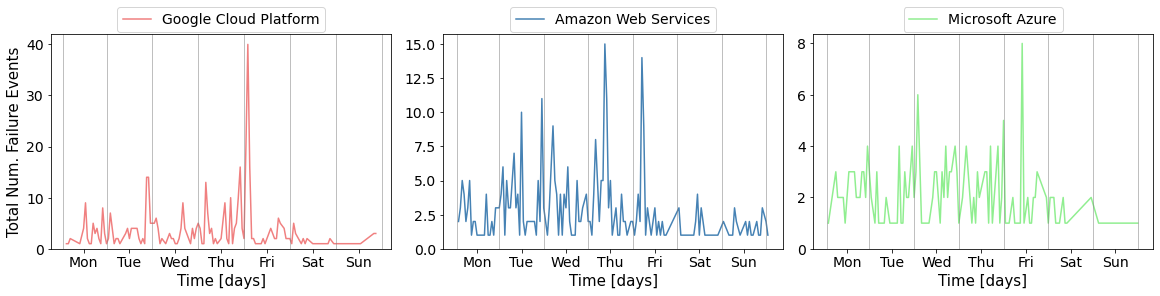

In [21]:
DAY = 24
MID_DAY = int(DAY / 2)
WEEK = 7 * DAY
colors = ["lightcoral", "steelblue", "lightgreen"]
cloud_map = {
    "AWS": "Amazon Web Services",
    "Azure": "Microsoft Azure",
    "GCP": "Google Cloud Platform"
}
providers = df["vendor"].unique()
fig, ax = plt.subplots(1, 3, figsize=(16, 4), constrained_layout=True)
for i, vendor in enumerate(providers):
    df_vendor = df[df["vendor"] == vendor]
    df_vendor['hour_of_week'] = df_vendor['event_start_time'].dt.dayofweek * 24 + (df['event_start_time'].dt.hour + 1)
    partial_grouped_df = df_vendor.groupby(['hour_of_week'])['event_start_time'].count().reset_index().rename(columns={'event_start_time': 'event_count'})
    ax[i].plot(partial_grouped_df["hour_of_week"], partial_grouped_df["event_count"], color=colors[i], label=cloud_map[vendor])
    ax[i].set_ylim(0, )
    ax[0].set_ylabel("Total Num. Failure Events", fontsize=15)
    ax[i].set_xlabel("Time [days]", fontsize=15)
    ax[i].tick_params(axis='both', labelsize=14)
    ax[i].set_xticks([tick for tick in range(MID_DAY-1, WEEK, DAY)])
    ax[i].set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], fontsize=14)
    ax[i].legend(loc='center', bbox_to_anchor=(0.5, 1.07), ncol=1, fontsize=14)
    xcoords = [0] + [xcoord for xcoord in range(23, WEEK, DAY)]
    for xc in xcoords:
        ax[i].axvline(x=xc, color="gray", lw=0.5)

plt.savefig(project_dir + "/plots/vendor_weekly_total_num_failure_events.pdf", dpi=100)

In [11]:
df['hour_of_week'] = df['event_start_time'].dt.dayofweek * 24 + (df['event_start_time'].dt.hour + 1)

In [15]:
df.groupby('hour_of_week')['event_start_time'].count()

hour_of_week
1      3
2      4
3      6
4      6
5      5
      ..
164    4
165    3
166    1
167    3
168    1
Name: event_start_time, Length: 160, dtype: int64